In [1]:
import warnings

import pandas as pd

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import scanpy as sc
import numpy as np
# import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# import altair as alt
import pertpy as pt

In [2]:
adata = sc.read(
    filename='haber_2017_regions.h5ad',
    # backup_url='https://figshare.com/ndownloader/files/38169900'
)

# This dataset contains 53,193 individual epithelial cells from the small intestine and organoids of mice

In [3]:
adata

AnnData object with n_obs × n_vars = 9842 × 15215
    obs: 'batch', 'barcode', 'condition', 'cell_label'

In [4]:
adata.obs

,batch,barcode,condition,cell_label
index,,,,
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor,B1,AAACATACCACAAC,Control,Enterocyte.Progenitor
B1_AAACGCACGAGGAC_Control_Stem,B1,AAACGCACGAGGAC,Control,Stem
B1_AAACGCACTAGCCA_Control_Stem,B1,AAACGCACTAGCCA,Control,Stem
B1_AAACGCACTGTCCC_Control_Stem,B1,AAACGCACTGTCCC,Control,Stem
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor,B1,AAACTTGACCACCT,Control,Enterocyte.Progenitor
...,...,...,...,...
B10_TTTCACGACAAGCT_Salmonella_TA,B10,TTTCACGACAAGCT,Salmonella,TA
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte,B10,TTTCAGTGAGGCGA,Salmonella,Enterocyte
B10_TTTCAGTGCGACAT_Salmonella_Stem,B10,TTTCAGTGCGACAT,Salmonella,Stem


The data was collected in 10 batches. Unique conditions are Control, Salmonella, Hpoly.Day3 and Hpoly.Day10 which correspond to the healthy control state, Salmonella infection, Heligmosomoides polygyrus infected cells after 3 days and Heligmosomoides polygyrus infected cells after 10 days.

# With labeled clusters

scCODA belongs to the family of tools that require pre-defined clusters, most commony cell types, to statistically derive changes in composition

In [5]:
# use load function to prepare a MuData object for subsequent processing, and it creates a compositional analysis dataset from the input adata
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_label",
    sample_identifier="batch",
    covariate_obs=["condition"],
)
sccoda_data

MuData object with n_obs × n_vars = 9852 × 15223
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'scCODA_sample_id'
    coda:	10 x 8
      obs:	'condition', 'batch'
      var:	'n_cells'

In [6]:
sccoda_data['coda']

# obs -> sample, var -> cell type

AnnData object with n_obs × n_vars = 10 × 8
    obs: 'condition', 'batch'
    var: 'n_cells'

In [7]:
sccoda_data['coda'].obs

,condition,batch
scCODA_sample_id,,
B1,Control,B1
B10,Salmonella,B10
B2,Control,B2
B3,Control,B3
B4,Control,B4
B5,Hpoly.Day3,B5
B6,Hpoly.Day3,B6
B7,Hpoly.Day10,B7
B8,Hpoly.Day10,B8


In [8]:
sccoda_data['coda'].var

,n_cells
cell_label,
Endocrine,380
Enterocyte,1458
Enterocyte.Progenitor,1822
Goblet,758
Stem,1857
TA,1188
TA.Early,1970
Tuft,409


<AxesSubplot: xlabel='Cell type', ylabel='Proportion'>

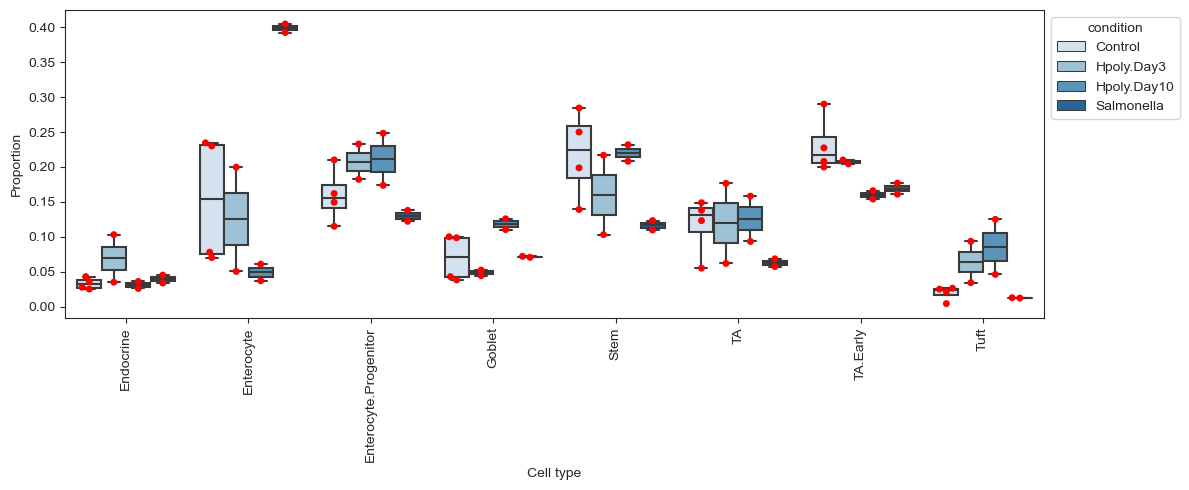

In [9]:
# overview of the cell type distributions across conditions

pt.pl.coda.boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="condition",
    figsize=(12, 5),
    add_dots=True,
    args_swarmplot={"palette": ["red"]},
)

<AxesSubplot: title={'center': 'condition'}, ylabel='Proportion'>

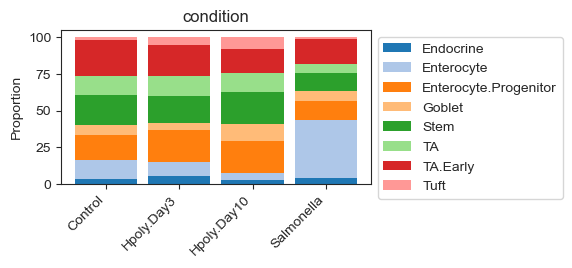

In [10]:
# stacked barplot displays the characteristics of compositional data
pt.pl.coda.stacked_barplot(
    sccoda_data, modality_key="coda", feature_name="condition", figsize=(4, 2)
)

In [11]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="condition",
    reference_cell_type="Endocrine",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|██████████| 11000/11000 [00:52<00:00, 209.12it/s, 79 steps of size 2.06e-02. acc. prob=0.79] 


In [12]:
sccoda_data["coda"].varm["effect_df_condition[T.Salmonella]"]

,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Cell Type,,,,,,,
Endocrine,0.000000,0.000,0.000,0.000,0.0000,32.521831,-0.527848
Enterocyte,1.547372,1.014,2.099,0.282,1.0000,383.095296,1.704538
Enterocyte.Progenitor,0.000000,-0.483,0.540,0.142,0.2827,125.953350,-0.527848
Goblet,0.000000,-0.320,1.016,0.291,0.4431,52.662920,-0.527848
Stem,0.000000,-0.742,0.301,0.175,0.3021,135.491865,-0.527848
TA,0.000000,-0.817,0.376,0.213,0.3548,78.957647,-0.527848
TA.Early,0.000000,-0.330,0.617,0.150,0.2962,152.461423,-0.527848
Tuft,0.000000,-1.302,0.558,0.359,0.4125,23.055667,-0.527848


In [13]:
sccoda_data

MuData object with n_obs × n_vars = 9852 × 15223
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'scCODA_sample_id'
    coda:	10 x 8
      obs:	'condition', 'batch'
      var:	'n_cells'
      uns:	'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'
      varm:	'intercept_df', 'effect_df_condition[T.Hpoly.Day3]', 'effect_df_condition[T.Hpoly.Day10]', 'effect_df_condition[T.Salmonella]'

In [14]:
# A smaller FDR value will produce more conservative results, but might miss some effects, 
# while a larger FDR value selects more effects at the cost of a larger number of false discoveries
sccoda_model.set_fdr(sccoda_data, 0.2)

In [15]:
# To get the binary classification of compositional changes per cell type we use the credible_effects function of scCODA on the result object.
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate                 Cell Type            
condition[T.Hpoly.Day3]   Endocrine                False
                          Enterocyte               False
                          Enterocyte.Progenitor    False
                          Goblet                   False
                          Stem                     False
                          TA                       False
                          TA.Early                 False
                          Tuft                     False
condition[T.Hpoly.Day10]  Endocrine                False
                          Enterocyte                True
                          Enterocyte.Progenitor    False
                          Goblet                   False
                          Stem                     False
                          TA                       False
                          TA.Early                 False
                          Tuft                      True
condition[T.Salmonella]   Endocrine     

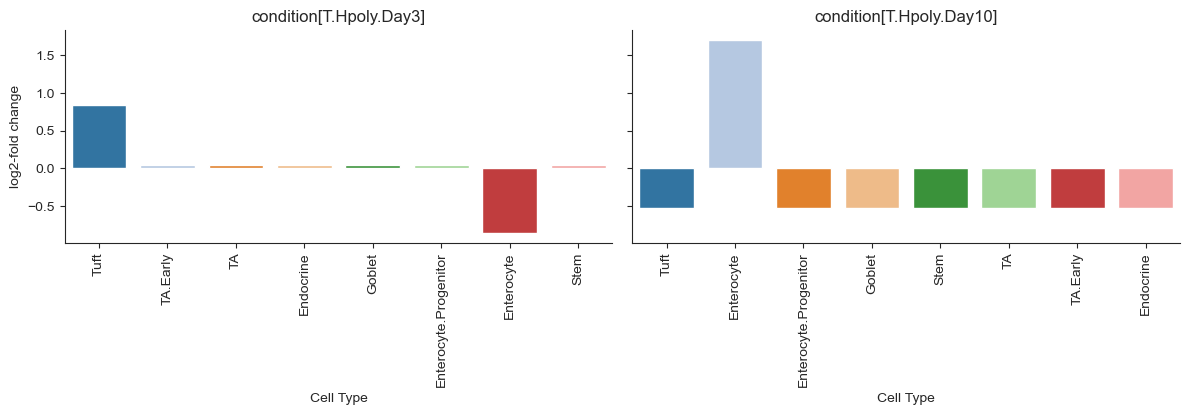

In [16]:
# To plot the fold changes together with the binary classification, we can easily use effects_bar_plot function.
pt.pl.coda.effects_barplot(sccoda_data, "coda", "condition")

In [20]:
sccoda_data

MuData object with n_obs × n_vars = 9852 × 15223
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'scCODA_sample_id'
    coda:	10 x 8
      obs:	'condition', 'batch'
      var:	'n_cells'
      uns:	'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'
      varm:	'intercept_df', 'effect_df_condition[T.Hpoly.Day3]', 'effect_df_condition[T.Hpoly.Day10]', 'effect_df_condition[T.Salmonella]'

# Key Takeaways
- If the primary interest lies in compositional changes among known cell-types or states, use scCODA or tascCODA to statistically evaluate changes in abundance.

- KNN based methods like DA-Seq or MILO should be used if the data does not cluster distinctly, such as during developmental processes, if we are interested in differences in cell abundances that might appear in transitional states between cell types or in a specific subset of cells of a given cell type.

In [18]:
import session_info

In [19]:
session_info.show()

More details about the compopsitional analysis can be found: https://www.sc-best-practices.org/conditions/compositional.html